# Hough Transform


In [44]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from math import radians, cos, sin

Detecting Edges using Hough Transform

In [55]:
def getHoughLines(im, mask):    

    # 2D median filter
    im_median = cv.medianBlur(im, 7)

    # Edge detection using Canny
    t_lower = 100
    t_upper = 200
    aperature_size = 3
    l2_gradient = False

    im_edges = cv.Canny(im_median, t_lower, t_upper, apertureSize=aperature_size, L2gradient=l2_gradient)

    # ROI selection (region of interest) - only the bottom half of the image
    im_roi = cv.bitwise_and(im_edges, im_edges, mask=mask)

    # Hough transform
    rho = 1
    theta = np.pi/180
    threshold = 15
    min_line_length = 15
    max_line_gap = 20

    lines_cart = cv.HoughLinesP(im_roi, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    lines_polar = cv.HoughLines(im_roi, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)


    return im_median, im_edges, im_roi, lines_polar, lines_cart


Refining coordinates to get best lines

In [56]:
def getStrongLines(houghLines, rho_allowance, theta_allowance, edge_count):

    strong_lines = np.zeros([edge_count,1,2])

    n2 = 0
    for n1 in range(len(houghLines)):
        for rho,theta in houghLines[n1]:
            if rho < 0:
                rho*=-1
                theta-=np.pi
            if n1 == 0:
                strong_lines[n2] = [[rho, theta]]
                n2 = n2 + 1
            else:
                closeness_rho = np.isclose(rho,strong_lines[0:n2,0,0],atol = rho_allowance)
                closeness_theta = np.isclose(theta,strong_lines[0:n2,0,1],atol = radians(theta_allowance))
                closeness = np.all([closeness_rho,closeness_theta],axis=0)
                if not any(closeness) and n2 < edge_count:
                    strong_lines[n2] = [[rho, theta]]
                    n2 = n2 + 1

    

    return strong_lines

Function to draw lines on an image

In [57]:
def drawLinesOnImg(img, lines, coord_system, mask):
    img_cpy = img.copy()
    
    if coord_system=='cart':
        # Draw Cartesian lines on the image
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv.line(img_cpy, (x1, y1), (x2, y2), (0, 255, 0), 2)

    elif coord_system=='polar':
        # Draw Polar lines on the image
        mask_lines = np.zeros(img.shape, dtype="uint8")

        for line in lines:

            rho, theta = line[0]

            a = cos(theta)
            b = sin(theta)
            x0 = a * rho
            y0 = b * rho

            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

            cv.line(mask_lines, pt1, pt2, [0,255,0], 5)

        mask_output = cv.bitwise_and(mask_lines, mask_lines, mask=mask[:,:,2])
        img_cpy = cv.addWeighted(img_cpy,1,mask_output,1,0)

    return img_cpy

Plotting Images

In [58]:
def plotImages(im_original, im_median, im_edges, im_roi, im_ht, im_ht_refined):    
    # Display images
    plt.figure(figsize=(20,8))

    plt.subplot(2, 3, 1)
    plt.imshow(im_original)
    plt.title("Original Image")
    
    plt.subplot(2, 3, 2)
    plt.imshow(im_edges, cmap="gray")
    plt.title("Edges")
    plt.subplot(2, 3, 3)
    plt.imshow(im_roi , cmap="gray")
    plt.title("ROI")

    plt.subplot(2, 3, 4)
    plt.imshow(im_median)
    plt.title("Median")

    plt.subplot(2, 3, 5)
    plt.imshow(im_ht)
    plt.title("Hough Transform")
    plt.subplot(2, 3, 6)
    plt.imshow(im_ht_refined)
    plt.title("HT Post-Processed")

    plt.show()



Testing

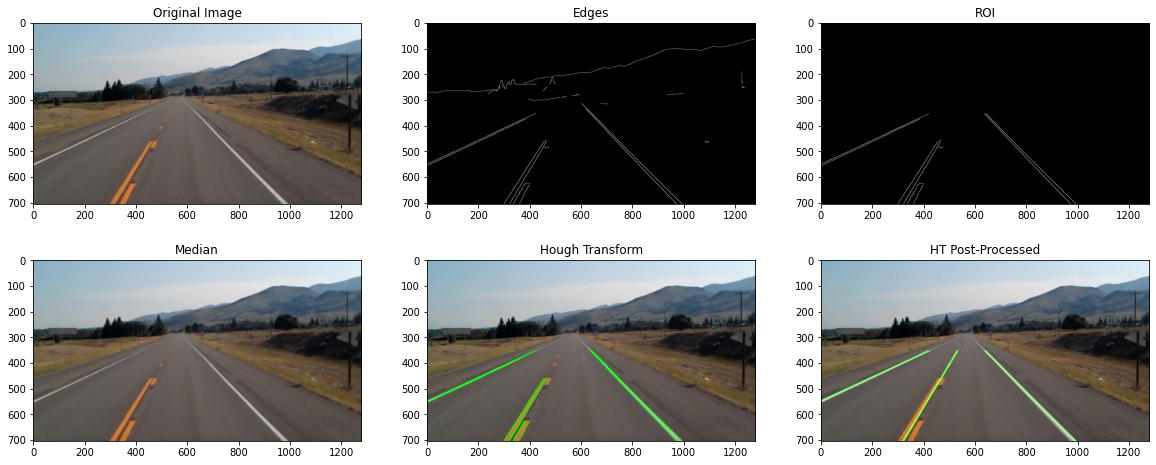

In [59]:
imgDir = '../testHough.jpg'
im = cv.imread(imgDir)
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

# Create mask to select ROI
roi_mask = np.zeros(im.shape[:2], dtype="uint8")
cv.rectangle(roi_mask, (0, int(im.shape[0]*0.5)), (1000, im.shape[0]), 255, -1)

# Perform Hough Transform
im_median, im_edges, im_roi, lines_polar, lines_cart = getHoughLines(im=im, mask=roi_mask)
im_ht = drawLinesOnImg(im, lines_cart, 'cart', roi_mask)

# Filtering Hough Lines 
required_edge_count = 3
ht_mask = cv.cvtColor(roi_mask, cv.COLOR_GRAY2RGB)
strong_lines = getStrongLines(houghLines=lines_polar, rho_allowance=50, theta_allowance=5, edge_count=required_edge_count)
im_ht_refined = drawLinesOnImg(im, strong_lines, 'polar', ht_mask)

# Plotting Results
plotImages(im, im_median, im_edges, im_roi, im_ht, im_ht_refined)

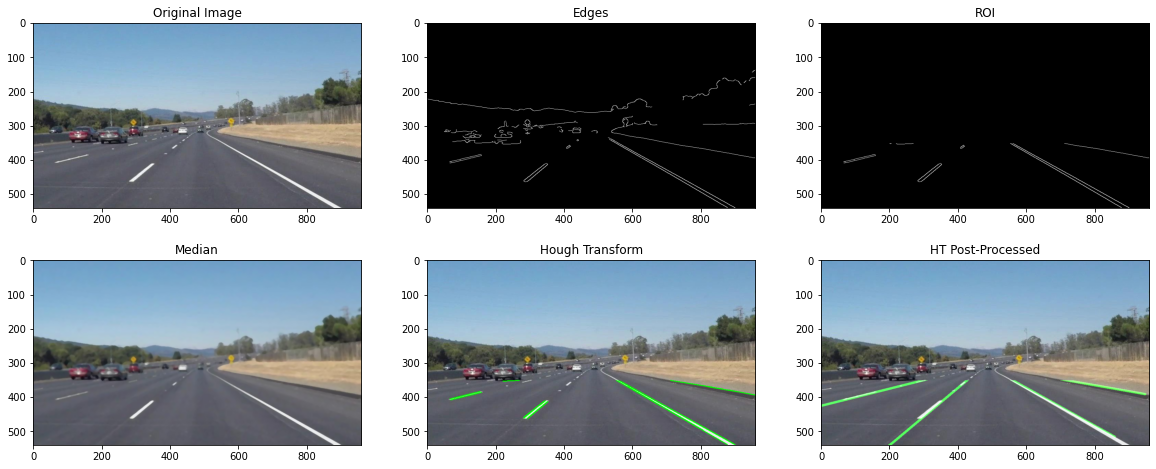

In [60]:
imgDir = '../Test Images/test1.jpeg'
im = cv.imread(imgDir)
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

# Create mask to select ROI
roi_mask = np.zeros(im.shape[:2], dtype="uint8")
cv.rectangle(roi_mask, (0, int(im.shape[0]*0.65)), (1000, im.shape[0]), 255, -1)

# Perform Hough Transform
im_median, im_edges, im_roi, lines_polar, lines_cart = getHoughLines(im=im, mask=roi_mask)
im_ht = drawLinesOnImg(im, lines_cart, 'cart', roi_mask)

# Filtering Hough Lines 
required_edge_count = 4
ht_mask = cv.cvtColor(roi_mask, cv.COLOR_GRAY2RGB)
strong_lines = getStrongLines(houghLines=lines_polar, rho_allowance=50, theta_allowance=5, edge_count=required_edge_count)
im_ht_refined = drawLinesOnImg(im, strong_lines, 'polar', ht_mask)

# Plotting Results
plotImages(im, im_median, im_edges, im_roi, im_ht, im_ht_refined)

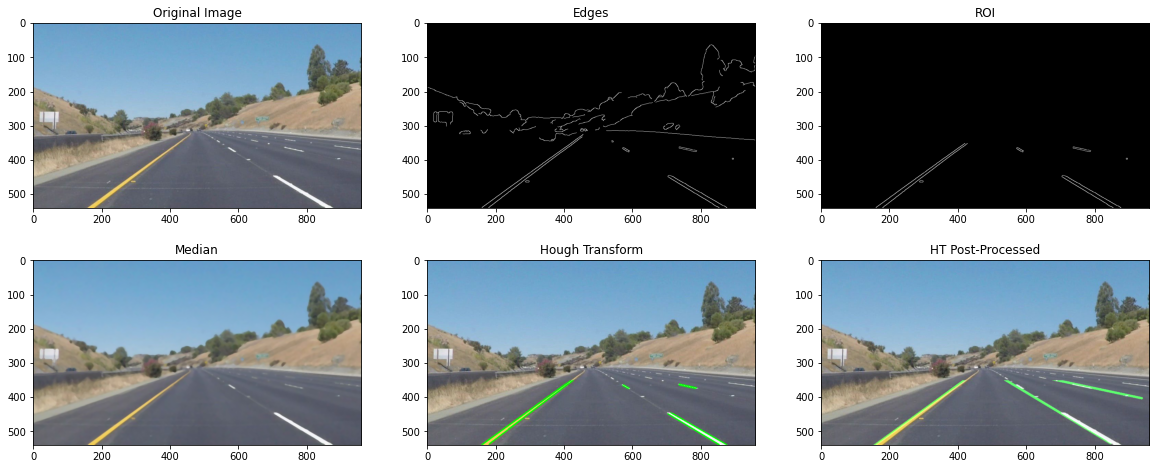

In [64]:
imgDir = '../Test Images/test2.jpeg'
im = cv.imread(imgDir)
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

# Create mask to select ROI
roi_mask = np.zeros(im.shape[:2], dtype="uint8")
cv.rectangle(roi_mask, (0, int(im.shape[0]*0.65)), (1000, im.shape[0]), 255, -1)

# Perform Hough Transform
im_median, im_edges, im_roi, lines_polar, lines_cart = getHoughLines(im=im, mask=roi_mask)
im_ht = drawLinesOnImg(im, lines_cart, 'cart', roi_mask)

# Filtering Hough Lines 
required_edge_count = 3
ht_mask = cv.cvtColor(roi_mask, cv.COLOR_GRAY2RGB)
strong_lines = getStrongLines(houghLines=lines_polar, rho_allowance=50, theta_allowance=180, edge_count=required_edge_count)
im_ht_refined = drawLinesOnImg(im, strong_lines, 'polar', ht_mask)

# Plotting Results
plotImages(im, im_median, im_edges, im_roi, im_ht, im_ht_refined)